# 实验四、水域分割

## 一、实验目的
编写m文件，实现给定图像的分割

## 二、实验报告要求
1. 参考附录的实验报告格式样本撰写。
2. “实验结果”主要包括：**基于标记的和非标记的两种水域分割结果图**、用于水域分割的**标记图**、将水域分割得到**结果**在原图上显示出来。
3. 实验报告附录中包含M-文件的源代码，要注意代码的格式。

## 三、实验原理
### 3.1 图像分割
图像分割就是把图像分成若干个特定的、具有独特性质的区域并提出感兴趣目标的技术和过程。

![image_segmentation](image_segmentation.png)

### 3.2 分水岭算法
分水岭算法(watershed algorithm)又称为水域分割，是一种数学形态学分割方法，基本思想是把图像看作地貌，图像中每一点像素的灰度值表示该点的海拔高度，每一个局部极小值及其影响区域称为集水盆，而集水盆的边界则形成分水岭。

分水岭的概念可通过模拟浸入过程来说明。在每一局部极小值表面，刺穿一个小孔，然后把整个模型慢慢浸入水中，随着浸入的加深，每一个局部极小值的影响域慢慢向外扩展，在两个集水盆汇合处构筑大坝，即形成分水岭。

![watershed_intro](watershed_intro.png)

水域分割一般是在**梯度图像**上实现，梯度图上的局部极小值一般代表较平滑的区域，即为目标中心区域或者变化不大的背景区域，集水形成的“分水岭”则位于梯度较大的**边缘区域**。

## 四、实验过程

### 4.1 无标记水域分割

In [1]:
% clear all data in the working space
clear all

% close all windows
close all 

% origin image
origin_img = imread('cells.png');
% [a, b, channel] = size(origin_img)

% gradient image
hy = fspecial('sobel');
hx = hy';
Iy = imfilter(double(origin_img), hy, 'replicate');
Ix = imfilter(double(origin_img), hx, 'replicate');
gradmag = sqrt(Ix.^2 + Iy.^2);

% watershed transform
L = watershed(gradmag);
Lrgb = label2rgb(L);

**API说明**：
1. $L = watershed(A)$：对输入矩阵$A$进行**分水岭变换**，得标签矩阵$L$。$L$中元素是非负整数,值为$0$的元素属于分水岭界限(watershed ridge line),值为$i(i\geq 1)$的元素属于第$i$个积水盆(catchment basin)。分水岭变换本质上是要把低海拔的积水盆地分离出来。

2. $label2rgb()$：转换标记矩阵到RGB图像(伪彩色图像)。


In [ ]:
figure;
subplot(2,2,1),imshow(origin_img);title('origin image')
subplot(2,2,2),imshow(gradmag, []), title('gradient image')
subplot(2,2,3),imshow(L,[0,1]),title('result');
subplot(2,2,4), imshow(Lrgb), title('label2rgb')

**API说明**：

1. $imshow(I,[low, high])$： 用指定的灰度范围$[low,high]$显示灰度图像$I$。图像中灰度值$\leq low$的都将用黑色显示，而灰度值$\geq high$都显示白色，介于low和high之间的用其灰度级的默认值的中间色调显示。用了空矩阵imshow([])将使用$[min(I(:)), \ max(I(:))]$作为参数。


###  4.2 带标记水域分割

不带标记的watershed容易过分割，带上标记符可以引导算法分割。
1. 前景标记(也称为内部标记):对象内部连接的像素。
2. 背景标记(也称为外部标记):不属于任何对象的像素。
3. 利用前景、背景标记来改进梯度幅值矩阵(最小覆盖算法)，在改进的梯度矩阵上再进行分水岭变换。

#### 4.2.1 前景标记构建

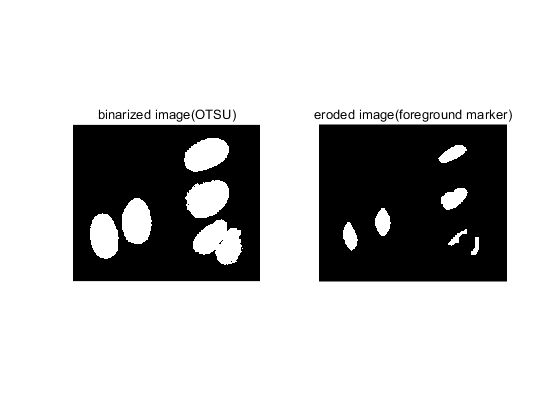

In [2]:
thresh = graythresh(origin_img);
bw = imbinarize(origin_img,thresh);
se = strel(ones(20,20));
%se = strel('disk',20);
eroded_image = imerode(bw, se);
figure;
subplot(121); imshow(bw); title('binarized image(OTSU)')
subplot(122); imshow(eroded_image); title('eroded image(foreground marker)');

### 4.2.2 背景标记构建

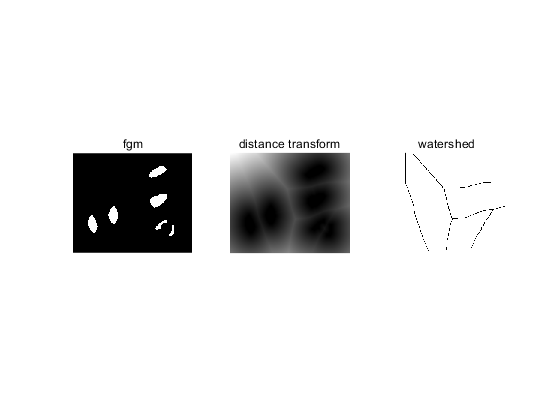

In [3]:
fgm = eroded_image;
D = bwdist(fgm);
D_ = watershed(D);
bgm = D_ == 0;
figure(1);
subplot(131);imshow(fgm);title('fgm');
subplot(132);imshow(D, []);title('distance transform');
subplot(133);imshow(D_, [0, 1]);title('watershed');

**API说明**:
1. $d = bwdist(bw)$：对二值化图像$bw$进行距离变换，变换结果是每个像素处存储该像素到最近灰度值为1像素的**距离**。

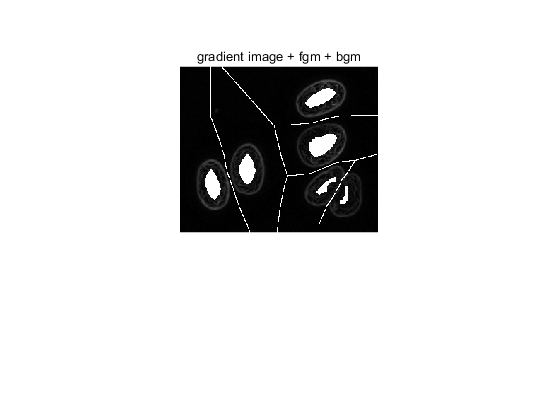

In [4]:
figure;
%image_ = origin_img;
image_ = gradmag;
image_(bgm | fgm) = 255;
imshow(image_, []); title('gradient image + fgm + bgm');

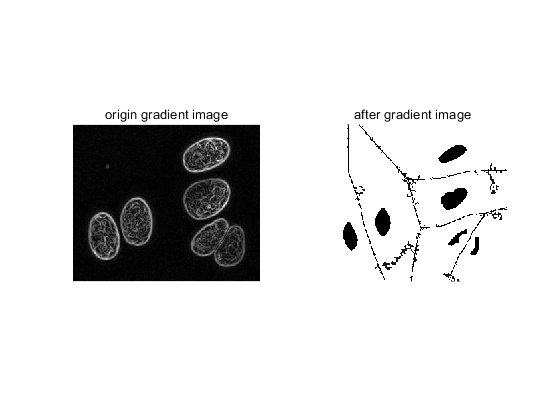

In [7]:
% smooth gradient image
gradmag2 = imimposemin(gradmag, bgm | fgm);
%gradmag2 = gradmag - gradmag2;
%max(gradmag2(:))
%min(gradmag2(:))
figure;
subplot(121);imshow(gradmag, []);title("origin gradient image");
subplot(122);imshow(gradmag2);title("after gradient image");

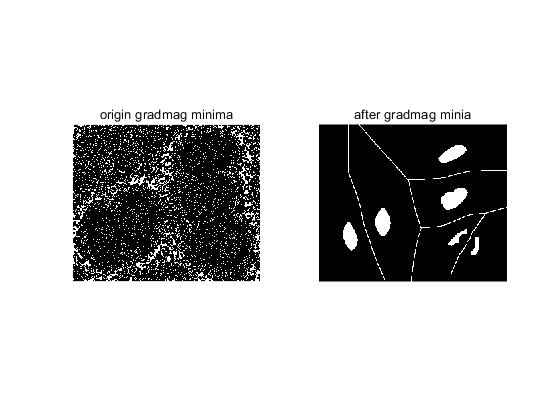

In [11]:
origin_min = imregionalmin(gradmag);
after_min = imregionalmin(gradmag2);
figure;
subplot(121);imshow(origin_min);title("origin gradmag minima");
subplot(122);imshow(after_min);title("after gradmag minia");

**API说明**:
1. $J = imimposemin(I,BW)$:使用形态学重建修改灰度掩模图像$I$，使其仅在二值标记图像$BW$非零时具有区域极小值。

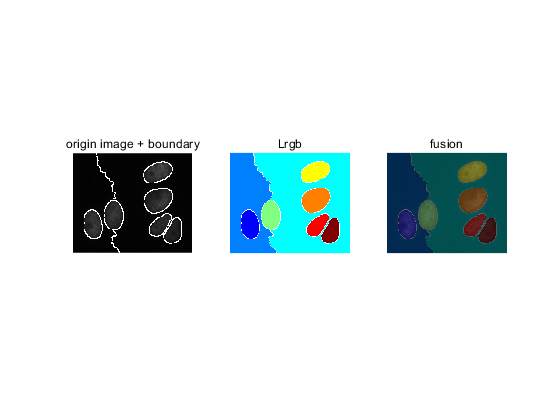

In [10]:
% result
L = watershed(gradmag2);
I4 = origin_img;
I4(imdilate(L == 0, ones(2, 2))) = 255;
figure; 
subplot(131); imshow(I4);title('origin image + boundary');
Lrgb = label2rgb(L);
subplot(132);imshow(Lrgb);title('Lrgb');
subplot(133);imshow(origin_img);title('fusion')
hold on
himage = imshow(Lrgb);
himage.AlphaData = 0.3;

## 五、思考
1. 为什么最终分水岭算法会多一条线？ 
2. 如何去除该线。
3. 参考API：imerode, imdilate,imopen, imclose, im2bw, bwdist, imimposemin;